# Other camera comparison

On a star-by-star basis can we use the other cameras to "normalise" the camera with a different voltage?

To investigate this, pick some bright stars in 802 (the one with a different voltage) and another camera.

We cannot use voltage 168 for this as the comparison data is much shorter.

Plot the two lightcurves in minute bins and compare the lightcurves.

In [160]:
%matplotlib inline
%load_ext autoreload
%autoreload 1

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import seaborn as sns

%aimport other_camera_analysis
o = other_camera_analysis

sns.set(style='white', context='poster')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's consider voltage 122 for the time being. The reference file is `data/122.fits`. The comparison file is:

In [161]:
target_file = 'data/122.fits'
comp_filename = '/ngts/pipedev/ParanalOutput/running-the-pipeline/20150609-ng2000-806/AperturePhot/output/20150609-ng2000-806/20150609-ng2000-806_image_NG2000-4501/output.fits'

These two files are at the same voltage so we expect very little difference.

In [162]:
data_target, data_comparison = o.Fits.from_file(target_file), o.Fits.from_file(comp_filename)

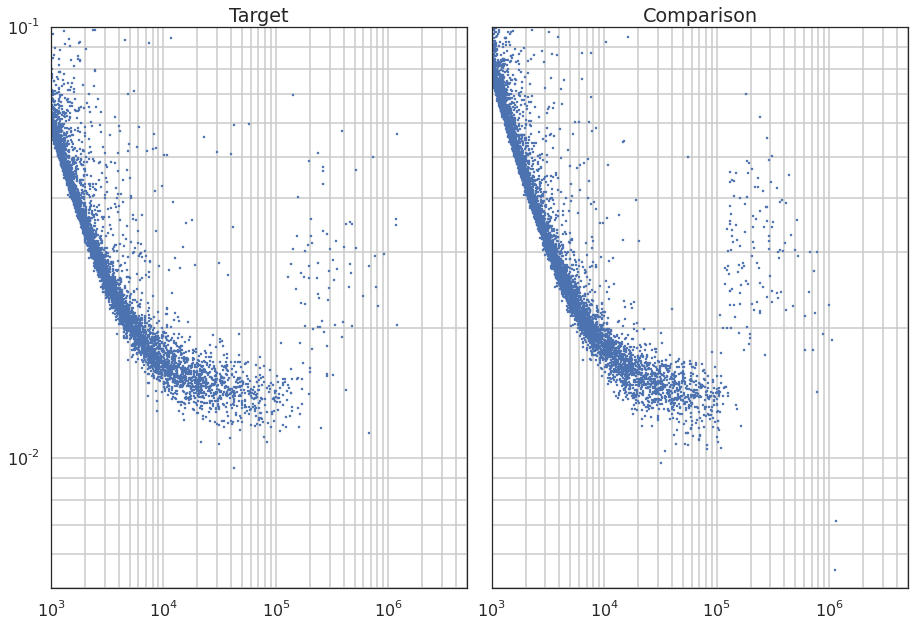

In [163]:
with o.subplots(1, 2, sharex=True, sharey=True) as (fig, axes):
    data_target.plot_frms(axes[0])
    data_comparison.plot_frms(axes[1])
    
    for ax in axes:
        ax.grid(True, which='both')
        ax.set(xlim=(1E3, 5E6), ylim=(5E-3, 1E-1))
    axes[0].set(title='Target')
    axes[1].set(title='Comparison')

There appears to be a higher sky background for the comparison flux measurements. The faint stars have a higher noise value than in the target flux. This may be a problem but let's power through for now...

Pick some stars in the non-sky-background-dominated region for study. They should also be near the centre of the chip.

In [164]:
star_ind = (data_target.flux_ind(2E4, 1E5) &
            data_target.frms_ind(1E-2, 3E-2) &
            data_target.ccdx_ind(768, 1280) &
            data_target.ccdy_ind(768, 1280))
assert star_ind.any()

In [165]:
chosen_target, chosen_comparison = (data_target.filter_by_star_ind(star_ind),
                                    data_comparison.filter_by_star_ind(star_ind))

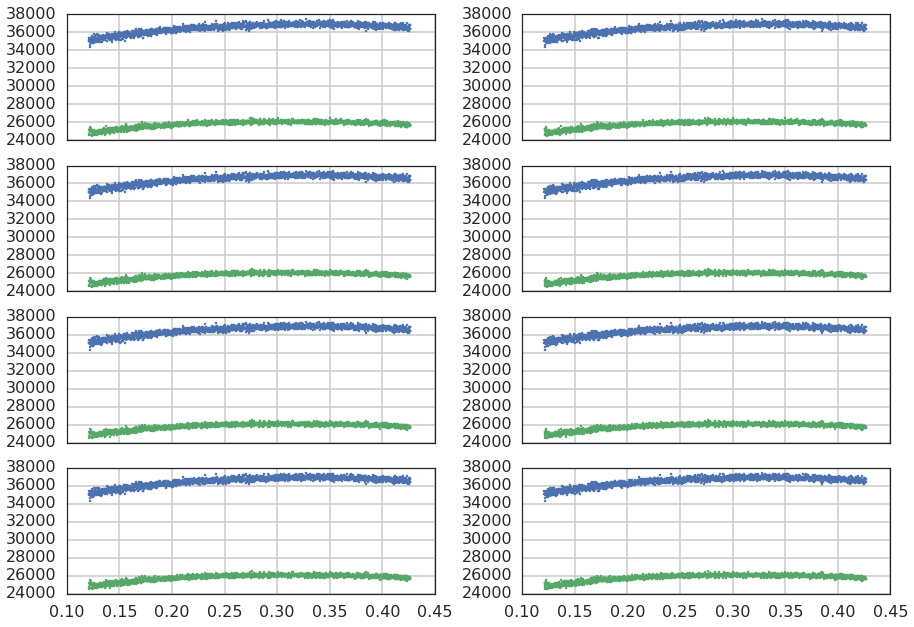

In [166]:
for (target, comparison, axis) in o.iterate_over_lightcurves(chosen_target, chosen_comparison):
    target, comparison = stars
    comparison.plot_lc(axis, ms=5)
    target.plot_lc(axis, ms=5)               

Clearly the absolute levels are different so lets normalise by their own medians:

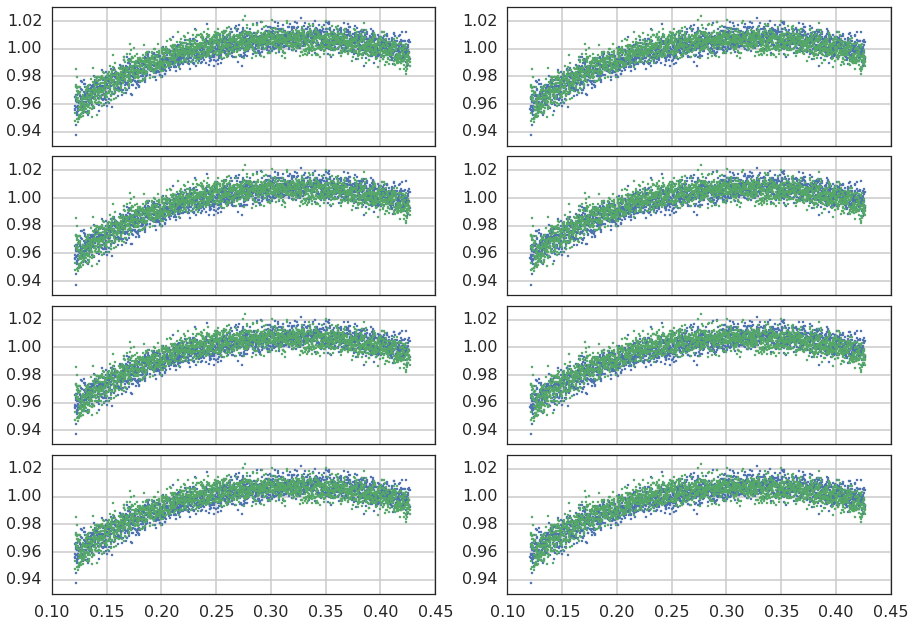

In [167]:
for (target, comparison, axis) in o.iterate_over_lightcurves(chosen_target, chosen_comparison):
    target, comparison = stars
    comparison.plot_lc(axis, ms=5, normalise=True)
    target.plot_lc(axis, ms=5, normalise=True)               

These look encouragingly similar, at least at the gross level. We now bin up to minutely bins.

In [168]:
bin_begin, bin_end = 0.1, 0.45
minute_bins_in_time = (bin_end - bin_begin) * 86400 / 60.
bins = np.linspace(bin_begin, bin_end, minute_bins_in_time)

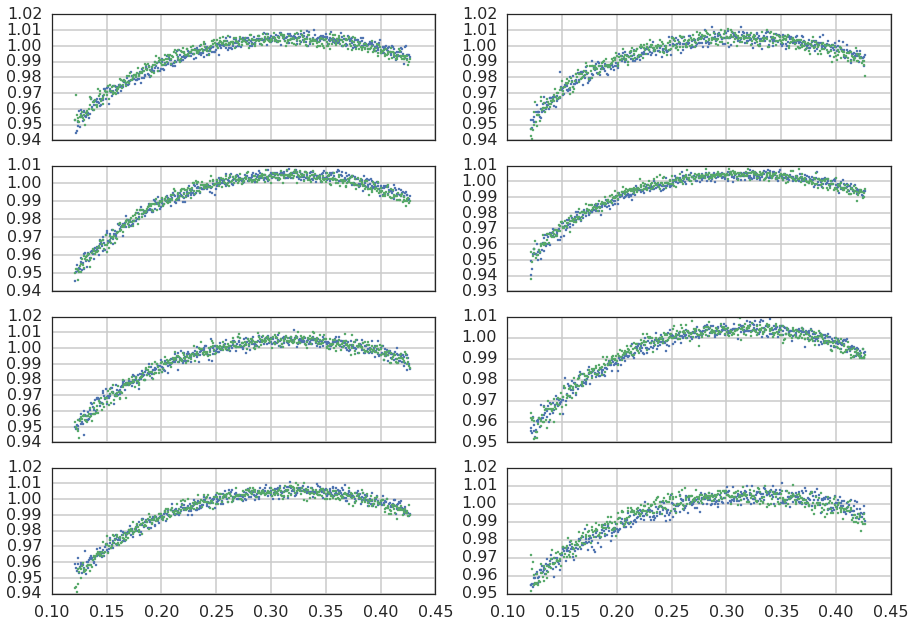

In [169]:
for (target, comparison, axis) in o.iterate_over_lightcurves(chosen_target, chosen_comparison):
    target_binned, comparison_binned = target.binned(bins), comparison.binned(bins)
    comparison_binned.plot_lc(axis, ms=5, normalise=True)
    target_binned.plot_lc(axis, ms=5, normalise=True)               

Now the differences

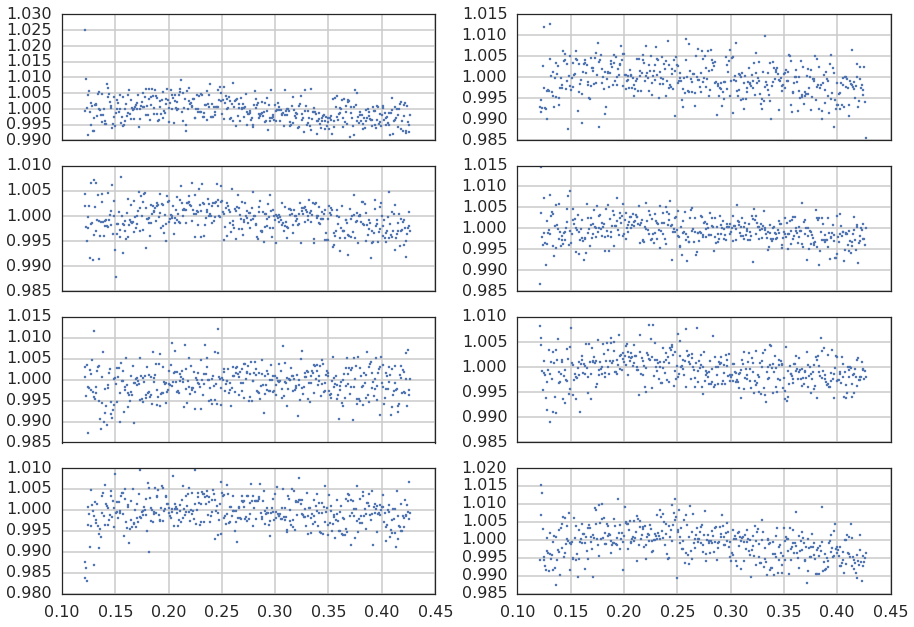

In [170]:
for (target, comparison, axis) in o.iterate_over_lightcurves(chosen_target, chosen_comparison):
    target_binned, comparison_binned = target.binned(bins), comparison.binned(bins)
    ratio = target_binned / comparison_binned
    ratio.plot_lc(axis, ms=5, normalise=True)

We can increase the bin factor to see how consistent they are with e.g. 10 minute bins.

In [171]:
ten_minute_bins_in_time = (bin_end - bin_begin) * 86400 / 60. / 10.
new_bins = np.linspace(bin_begin, bin_end, ten_minute_bins_in_time)

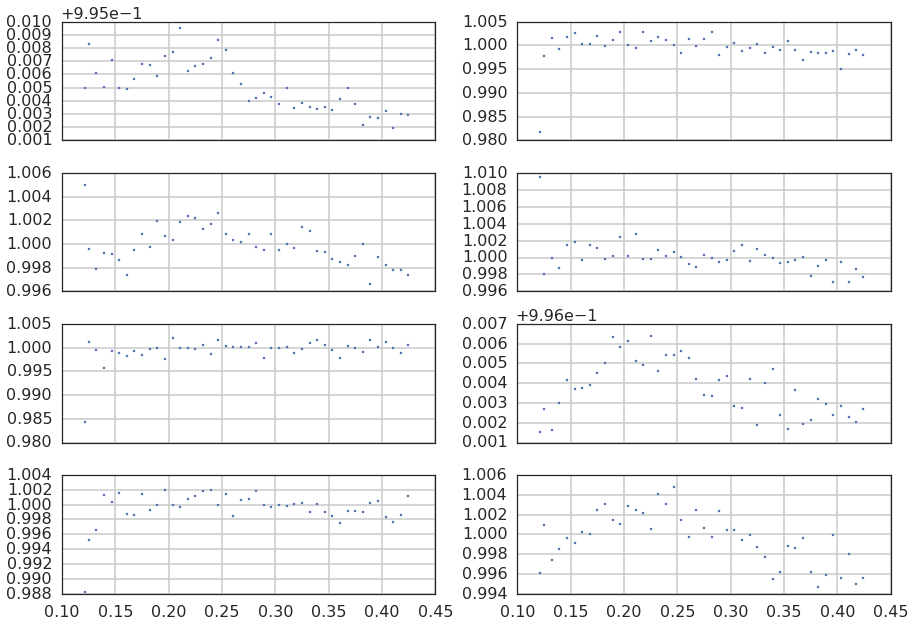

In [172]:
for (target, comparison, axis) in o.iterate_over_lightcurves(chosen_target, chosen_comparison):
    target_binned, comparison_binned = target.binned(new_bins), comparison.binned(new_bins)
    ratio = target_binned / comparison_binned
    ratio.plot_lc(axis, ms=5, normalise=True)

Some of these lightcurves are similar on 10 minute timescales to < 2 mmag which is great. Others are not.

The main problem with this is the mean flux levels. We can get around this by starting with the same voltages when testing the "test" camera and using the offsets to calibrate the differences. The other problem is that we are assuming we can use the full range of fluxes to sample the equivalent of the "exposure time" axis from the lab tests. The outline above was tested with the bright stars only, so two options present themselves:

* we have to test the faint stars as well to see if the similarities apply acrosso teh whole brightness range, or
* we use the bright stars (which we've shown to be consistent) to calibrate the entire flux range

The latter will work assuming a constant gain, but we believe this is not the case when changing voltages.